In [ ]:
# ====== Cell 1: Libraries & helpers ======
import pandas as pd
import numpy as np
import os
import json
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="whitegrid")

# helper: safe read csv with encoding fallbacks
def safe_read_csv(path):
    try:
        return pd.read_csv(path, encoding='utf-8')
    except Exception as e1:
        try:
            return pd.read_csv(path, encoding='latin1')
        except Exception as e2:
            return pd.read_csv(path, engine='python')

# helper: print separator
def sep(msg):
    print("\n"+"="*8 + " " + msg + " " + "="*8 + "\n")


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Country-Code.xlsx to Country-Code.xlsx
Saving zomato.csv to zomato.csv


In [ ]:
import os
os.listdir()


['.config', 'Country-Code.xlsx', 'zomato.csv', 'sample_data']

In [ ]:
df = safe_read_csv('zomato.csv')
df.head()


,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [ ]:
# ====== Cell 5: Load Country-Code.xlsx (optional) ======
country_df = None
if os.path.exists('Country-Code.xlsx'):
    try:
        country_df = pd.read_excel('Country-Code.xlsx')
        sep("Country-Code loaded")
        display(country_df.head())
    except Exception as e:
        print("Country-Code.xlsx read error:", e)
else:
    print("Country-Code.xlsx nahi mila — skip kar raha hoon.")



======== Country-Code loaded ========



,Country Code,Country
0,1,India
1,14,Australia
2,30,Brazil
3,37,Canada
4,94,Indonesia


In [ ]:
# ====== Cell 7: Basic inspection ======
sep("Basic Info")
print("Rows,Cols:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nNulls (top 15):")
print(df.isnull().sum().sort_values(ascending=False).head(15))



======== Basic Info ========

Rows,Cols: (9551, 21)

Data types:
Restaurant ID             int64
Restaurant Name          object
Country Code              int64
City                     object
Address                  object
Locality                 object
Locality Verbose         object
Longitude               float64
Latitude                float64
Cuisines                 object
Average Cost for two      int64
Currency                 object
Has Table booking        object
Has Online delivery      object
Is delivering now        object
Switch to order menu     object
Price range               int64
Aggregate rating        float64
Rating color             object
Rating text              object
Votes                     int64
dtype: object

Nulls (top 15):
Cuisines                9
Restaurant Name         0
Country Code            0
City                    0
Restaurant ID           0
Address                 0
Locality                0
Longitude               0
Locality Verbose       

In [ ]:
# ====== Cell 8: Standardize some common column names (safe) ======
# We'll map common variants to standard names used in rest of notebook:
col_map = {}
cols = [c.lower().strip() for c in df.columns]

# helper to find column by keyword
def find_col(keywords):
    for i,c in enumerate(df.columns):
        name = c.lower()
        for k in keywords:
            if k in name:
                return c
    return None

# possible columns
mapping = {
    'restaurant_id': find_col(['restaurant id','id']),
    'name': find_col(['name','restaurant name']),
    'country_code': find_col(['country code','country_code','countrycode']),
    'city': find_col(['city','location','locality','area']),
    'avg_cost_two': find_col(['cost','average_cost_for_two','avg_cost','average cost']),
    'cuisines': find_col(['cuisine','cuisines']),
    'aggregate_rating': find_col(['aggregate_rating','rating','aggregate rating']),
    'votes': find_col(['votes','vote']),
    'has_online_delivery': find_col(['online delivery','has_online_delivery']),
    'listed_in_type': find_col(['listed_in_type','type']),
    'address': find_col(['address']),
    'latitude': find_col(['lat']),
    'longitude': find_col(['lon','lng','long'])
}

# build actual mapping for df.rename
actual_map = {}
for std, col in mapping.items():
    if col:
        actual_map[col] = std

if actual_map:
    df.rename(columns=actual_map, inplace=True)
    print("Columns renamed (detected):")
    print(actual_map)
else:
    print("Koi common column rename detect nahi hua. Current columns kept.")

print("Now columns:", df.columns.tolist())


Columns renamed (detected):
{'Restaurant ID': 'restaurant_id', 'Restaurant Name': 'name', 'Country Code': 'country_code', 'City': 'city', 'Average Cost for two': 'avg_cost_two', 'Cuisines': 'cuisines', 'Aggregate rating': 'aggregate_rating', 'Votes': 'votes', 'Has Online delivery': 'has_online_delivery', 'Address': 'address', 'Latitude': 'latitude', 'Longitude': 'longitude'}
Now columns: ['restaurant_id', 'name', 'country_code', 'city', 'address', 'Locality', 'Locality Verbose', 'longitude', 'latitude', 'cuisines', 'avg_cost_two', 'Currency', 'Has Table booking', 'has_online_delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'aggregate_rating', 'Rating color', 'Rating text', 'votes']


In [ ]:
# ====== Cell 9: Basic cleaning ======
sep("Cleaning start")

# drop duplicates
before = df.shape[0]
df.drop_duplicates(inplace=True)
after = df.shape[0]
print(f"Duplicates removed: {before-after}")

# trim string cols
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# numeric conversions: rating
if 'aggregate_rating' in df.columns:
    df['aggregate_rating'] = pd.to_numeric(df['aggregate_rating'], errors='coerce')

# avg cost conversions
if 'avg_cost_two' in df.columns:
    df['avg_cost_two'] = df['avg_cost_two'].astype(str).str.replace(',','').str.replace('₹','').str.extract('(\d+)')[0]
    df['avg_cost_two'] = pd.to_numeric(df['avg_cost_two'], errors='coerce')

# votes numeric
if 'votes' in df.columns:
    df['votes'] = pd.to_numeric(df['votes'], errors='coerce')

print("After basic cleaning, nulls top 10:")
print(df.isnull().sum().sort_values(ascending=False).head(10))



======== Cleaning start ========

Duplicates removed: 0
After basic cleaning, nulls top 10:
restaurant_id       0
name                0
country_code        0
city                0
address             0
Locality            0
Locality Verbose    0
longitude           0
latitude            0
cuisines            0
dtype: int64


<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-63896870.py:20: SyntaxWarning: invalid escape sequence '\d'
  df['avg_cost_two'] = df['avg_cost_two'].astype(str).str.replace(',','').str.replace('₹','').str.extract('(\d+)')[0]


In [ ]:
# ====== Cell 10: Merge Country-Code (if available) ======
if country_df is not None and 'country_code' in df.columns:
    # try common country code column name in country_df
    cc_col = None
    for candidate in ['Country Code','Country_Code','country code','country_code','Country code']:
        if candidate in country_df.columns:
            cc_col = candidate
            break
    if cc_col is None and 'country code' in " ".join(country_df.columns).lower():
        cc_col = country_df.columns[0]  # fallback
    if cc_col is None:
        print("Country-Code.xlsx however its column couldn't be detected automatically. Showing columns:")
        display(country_df.columns)
    else:
        # try name column e.g., 'Country' or 'Country Name'
        name_col = None
        for candidate in ['Country','Country Name','Country_Name','Country name']:
            if candidate in country_df.columns:
                name_col = candidate
                break
        if name_col is None:
            # fallback to second column
            possible = [c for c in country_df.columns if c!=cc_col]
            if possible:
                name_col = possible[0]
        # rename keys and merge
        country_df_ren = country_df.rename(columns={cc_col:'country_code', name_col:'country'})
        df = df.merge(country_df_ren[['country_code','country']].drop_duplicates(), on='country_code', how='left')
        print("Country merged. Unique countries:", df['country'].nunique() if 'country' in df.columns else "N/A")
else:
    print("Country-Code not merged (missing or no country_code column).")


Country merged. Unique countries: 15


In [13]:
# ====== Cell 11: Missing handling & simple feature engineering ======
sep("Missing handling & feature engineering")

# fill some obvious nulls
if 'cuisines' in df.columns:
    df['cuisines'] = df['cuisines'].replace('nan', np.nan)
    df['cuisines'].fillna('Unknown', inplace=True)

if 'has_online_delivery' in df.columns:
    # convert to numeric if '0'/'1' strings
    df['has_online_delivery'] = df['has_online_delivery'].replace({'Yes':1,'No':0,'0':0,'1':1}).fillna(0).astype(int)

# Price bracket
if 'avg_cost_two' in df.columns:
    df['price_bracket'] = pd.cut(df['avg_cost_two'].fillna(0),
                                 bins=[-1,200,500,1000,100000],
                                 labels=['Cheap','Affordable','Expensive','Premium'])

# rating label
if 'aggregate_rating' in df.columns:
    df['rating_label'] = df['aggregate_rating'].apply(lambda x: 'NoRating' if pd.isna(x) else ('Low' if x<3 else ('Medium' if x<4 else 'High')))

print("Sample of engineered columns:")
display(df[['cuisines','price_bracket','rating_label']].head())



======== Missing handling & feature engineering ========

Sample of engineered columns:


/tmp/ipython-input-2060122417.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['cuisines'].fillna('Unknown', inplace=True)


,cuisines,price_bracket,rating_label
0,"French, Japanese, Desserts",Premium,High
1,Japanese,Premium,High
2,"Seafood, Asian, Filipino, Indian",Premium,High
3,"Japanese, Sushi",Premium,High
4,"Japanese, Korean",Premium,High



======== EDA charts ========



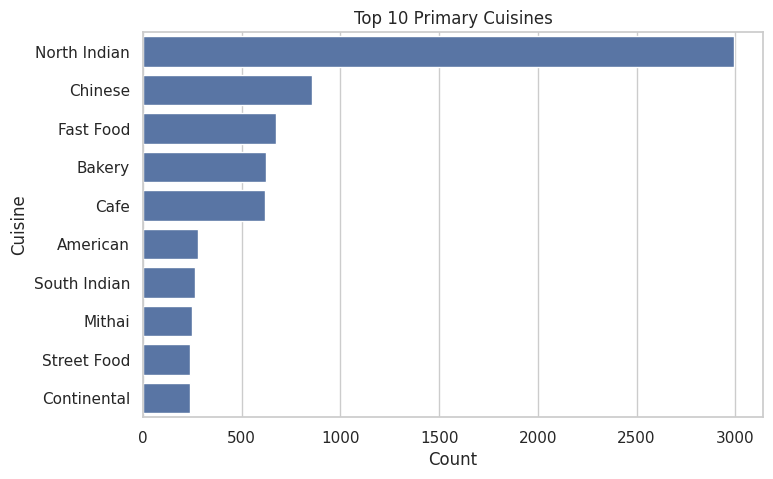

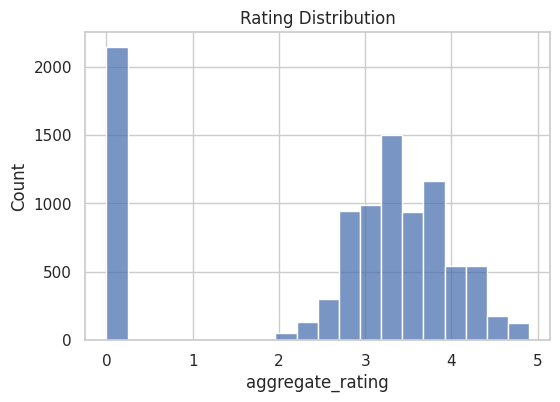

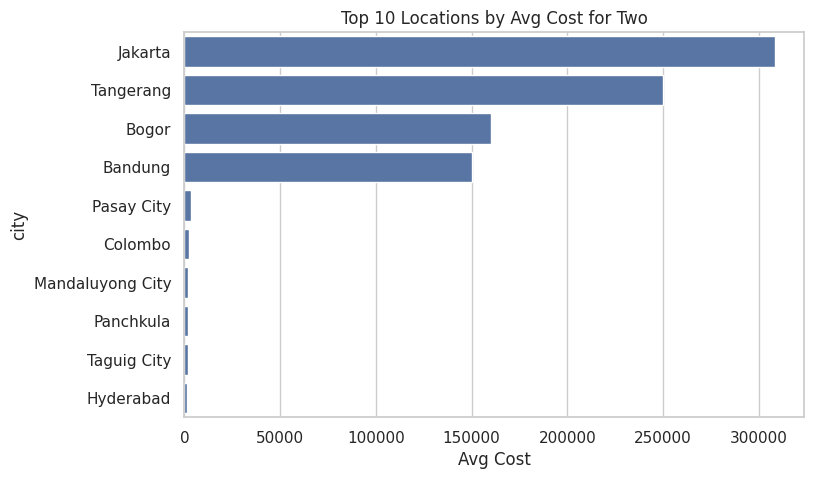

In [14]:
# ====== Cell 12: EDA charts ======
sep("EDA charts")

# Top cuisines (split by comma, explode)
if 'cuisines' in df.columns:
    # take first cuisine as representative for simplicity
    df['primary_cuisine'] = df['cuisines'].astype(str).str.split(',').str[0]
    top_cuis = df['primary_cuisine'].value_counts().nlargest(10)
    plt.figure(figsize=(8,5))
    sns.barplot(y=top_cuis.index, x=top_cuis.values)
    plt.title('Top 10 Primary Cuisines')
    plt.xlabel('Count'); plt.ylabel('Cuisine')
    plt.show()

# Rating distribution
if 'aggregate_rating' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['aggregate_rating'].dropna(), bins=20)
    plt.title('Rating Distribution')
    plt.show()

# Avg cost by city/locality (top 10)
city_col = None
for c in ['city','location','locality','area']:
    if c in df.columns:
        city_col = c
        break

if city_col and 'avg_cost_two' in df.columns:
    tmp = df.groupby(city_col)['avg_cost_two'].mean().dropna().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(y=tmp.index, x=tmp.values)
    plt.title('Top 10 Locations by Avg Cost for Two')
    plt.xlabel('Avg Cost'); plt.ylabel(city_col)
    plt.show()


In [15]:
# ====== Cell 13: Summary tables for report ======
sep("Key Summaries")

# top 10 restaurants by rating
if 'aggregate_rating' in df.columns:
    best = df[['name', city_col, 'primary_cuisine','aggregate_rating']].sort_values('aggregate_rating', ascending=False).drop_duplicates().head(10)
    print("Top rated restaurants sample:")
    display(best)

# number of restaurants per city
if city_col:
    counts = df[city_col].value_counts().head(15)
    print("Top locations by restaurant count:")
    display(counts)

# avg rating & cost per location (top 10 by count)
if city_col and 'aggregate_rating' in df.columns:
    summary = df.groupby(city_col).agg({'aggregate_rating':'mean','avg_cost_two':'mean','name':'count'}).rename(columns={'name':'num_restaurants'})
    summary = summary.sort_values('num_restaurants', ascending=False).head(10)
    print("Summary (top locations):")
    display(summary)



======== Key Summaries ========

Top rated restaurants sample:


,name,city,primary_cuisine,aggregate_rating
8,Spiral - Sofitel Philippine Plaza Manila,Pasay City,European,4.9
10,Silantro Fil-Mex,Pasig City,Filipino,4.9
3,Ooma,Mandaluyong City,Japanese,4.9
9458,Urbanologi,Inner City,Tapas,4.9
507,Mazzaro's Italian Market,Tampa Bay,Italian,4.9
509,Mr. Dunderbak's Biergarten and Marketplatz,Tampa Bay,European,4.9
429,Marukame Udon,Rest of Hawaii,Japanese,4.9
428,Mama's Fish House,Rest of Hawaii,Hawaiian,4.9
580,Punjab Grill,Abu Dhabi,Indian,4.9
589,AB's Absolute Barbecues,Dubai,Continental,4.9


Top locations by restaurant count:


,count
city,
New Delhi,5473
Gurgaon,1118
Noida,1080
Faridabad,251
Ghaziabad,25
Bhubaneshwar,21
Lucknow,21
Ahmedabad,21
Amritsar,21


Summary (top locations):


,aggregate_rating,avg_cost_two,num_restaurants
city,,,
New Delhi,2.438845,596.088069,5473
Gurgaon,2.651431,714.016100,1118
Noida,2.036204,539.490741,1080
Faridabad,1.866932,447.609562,251
Ghaziabad,2.852000,602.000000,25
Bhubaneshwar,3.980952,678.571429,21
Lucknow,4.195238,859.523810,21
Guwahati,4.190476,821.428571,21
Ahmedabad,4.161905,857.142857,21


In [16]:
# ====== Cell 14: Optional - simple ML model to predict high rating ======
do_ml = True
if do_ml and 'aggregate_rating' in df.columns:
    # make a tiny feature set
    features = []
    if 'avg_cost_two' in df.columns: features.append('avg_cost_two')
    if 'votes' in df.columns: features.append('votes')
    if 'has_online_delivery' in df.columns: features.append('has_online_delivery')

    # if primary_cuisine exists, one-hot top 10
    if 'primary_cuisine' in df.columns:
        top_cuis = df['primary_cuisine'].value_counts().nlargest(10).index.tolist()
        for c in top_cuis:
            colname = f"cuisine_{c.strip().replace(' ','_')}"
            df[colname] = (df['primary_cuisine']==c).astype(int)
            features.append(colname)

    # ensure at least one feature
    if len(features) >= 1:
        df_ml = df[features + ['aggregate_rating']].dropna()
        X = df_ml[features]
        y = (df_ml['aggregate_rating'] >= 4).astype(int)

        from sklearn.model_selection import train_test_split
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        print("Accuracy:", accuracy_score(y_test, preds))
        print("Classification report:")
        print(classification_report(y_test, preds))

        # feature importances
        importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
        print("Top feature importances:")
        display(importances)
    else:
        print("Koi usable numeric features nahi mile ML ke liye.")
else:
    print("ML skipped (no rating column).")


Accuracy: 0.8749345892203035
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1636
           1       0.58      0.47      0.52       275

    accuracy                           0.87      1911
   macro avg       0.75      0.70      0.72      1911
weighted avg       0.87      0.87      0.87      1911

Top feature importances:


,0
votes,0.613392
avg_cost_two,0.291636
has_online_delivery,0.023160
cuisine_North_Indian,0.016393
cuisine_Cafe,0.009123
cuisine_Chinese,0.008269
cuisine_Continental,0.007690
cuisine_American,0.006644
cuisine_Street_Food,0.006339
cuisine_Bakery,0.005890


In [17]:
# ====== Cell 15: Save cleaned CSV & model if any ======
clean_path = 'zomato_cleaned.csv'
df.to_csv(clean_path, index=False)
print("Cleaned CSV saved to:", clean_path)

# Save model if trained
if 'clf' in globals():
    import joblib
    joblib.dump(clf, 'rating_rf_model.pkl')
    print("Model saved as rating_rf_model.pkl")


Cleaned CSV saved to: zomato_cleaned.csv
Model saved as rating_rf_model.pkl


In [18]:
# ====== Cell 16: Auto-generate short README text (print) ======
readme = f"""
Project: Zomato Data Analysis (auto-generated summary)
Files used: zomato.csv{', Country-Code.xlsx' if country_df is not None else ''}
Rows: {df.shape[0]}, Columns: {df.shape[1]}

Key steps performed:
1. Basic cleaning (duplicates, numeric conversions)
2. Feature engineering (primary_cuisine, price_bracket, rating_label)
3. EDA: Top cuisines, rating distribution, cost by location
4. Optional ML: RandomForest to predict high rating (if enough data)
5. Saved cleaned CSV: {clean_path}

How to reproduce: Run this notebook cells in order in Google Colab.
"""
print(readme)
with open('README_auto.txt','w', encoding='utf-8') as f:
    f.write(readme)
print("README_auto.txt saved.")



Project: Zomato Data Analysis (auto-generated summary)
Files used: zomato.csv, Country-Code.xlsx
Rows: 9551, Columns: 35

Key steps performed:
1. Basic cleaning (duplicates, numeric conversions)
2. Feature engineering (primary_cuisine, price_bracket, rating_label)
3. EDA: Top cuisines, rating distribution, cost by location
4. Optional ML: RandomForest to predict high rating (if enough data)
5. Saved cleaned CSV: zomato_cleaned.csv

How to reproduce: Run this notebook cells in order in Google Colab.

README_auto.txt saved.


In [19]:
# ====== Cell 17: Next steps (instructions) ======
print("""
NEXT STEPS (suggested):
1) Download 'zomato_cleaned.csv' and use for PowerPoint visuals.
2) Create 4-6 slide PPT: Problem, Data source, Key findings (3 bullets), Top visuals, Conclusion.
3) If you want interactive dashboard: I can provide Streamlit app code next (simple filter + charts).
4) If you want GitHub-ready: move notebook + cleaned csv + README to a repo and share link.

Agar chaho, ab main Streamlit app code bhi de doon tumhare liye.
Bol do: "STREAMLIT DOGA" ya "PPT DOGA" ya "GITHUB README improve kar".
""")



NEXT STEPS (suggested):
1) Download 'zomato_cleaned.csv' and use for PowerPoint visuals.
2) Create 4-6 slide PPT: Problem, Data source, Key findings (3 bullets), Top visuals, Conclusion.
3) If you want interactive dashboard: I can provide Streamlit app code next (simple filter + charts).
4) If you want GitHub-ready: move notebook + cleaned csv + README to a repo and share link.

Agar chaho, ab main Streamlit app code bhi de doon tumhare liye.
Bol do: "STREAMLIT DOGA" ya "PPT DOGA" ya "GITHUB README improve kar".

